# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,1.043443,False,3.288370
1,-0.719086,True,3.827861
2,0.967549,False,2.757559
3,-0.676069,False,-2.196697
4,0.240388,True,6.114017
...,...,...,...
995,-1.173342,True,3.233798
996,1.061021,False,0.766653
997,1.812507,True,8.387034
998,1.389300,False,1.748483


<Axes: xlabel='v0'>

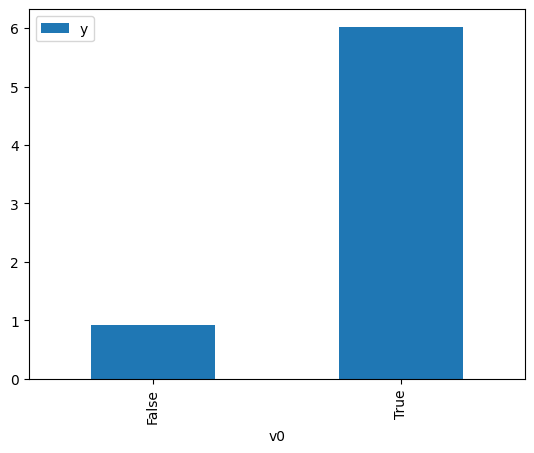

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

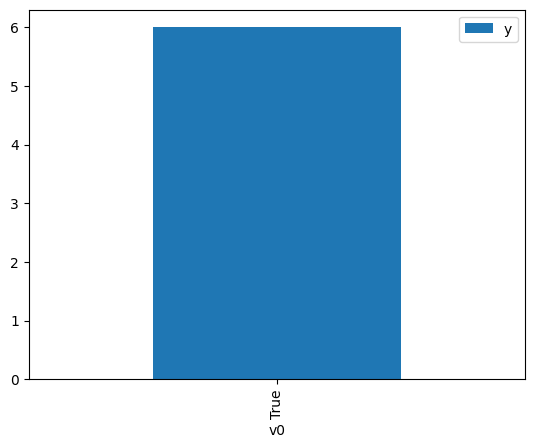

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.251503,False,4.648686,0.445524,2.244549
1,2.575259,False,6.555148,0.396166,2.524197
2,0.840849,False,1.729413,0.461105,2.168702
3,2.991209,False,5.811982,0.381035,2.624432
4,1.165415,False,1.450720,0.448782,2.228251
...,...,...,...,...,...
995,1.095525,False,2.874825,0.451431,2.215177
996,1.061021,False,0.766653,0.452740,2.208774
997,1.095525,False,2.874825,0.451431,2.215177
998,-0.010993,False,0.013939,0.493636,2.025785


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.212877,True,3.122988,0.514930,1.942011
1,0.791773,True,9.022931,0.537027,1.862104
2,0.626781,True,6.875759,0.530740,1.884162
3,0.119495,True,6.846478,0.511358,1.955578
4,-0.397422,True,4.782325,0.491573,2.034286
...,...,...,...,...,...
995,0.592020,True,7.671610,0.529414,1.888880
996,-0.193414,True,4.251908,0.499382,2.002477
997,-0.764507,True,5.038481,0.477535,2.094087
998,0.669331,True,5.780822,0.532362,1.878420


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.963
Model:                            OLS   Adj. R-squared (uncentered):              0.963
Method:                 Least Squares   F-statistic:                          1.301e+04
Date:                Tue, 22 Oct 2024   Prob (F-statistic):                        0.00
Time:                        01:09:26   Log-Likelihood:                         -1420.6
No. Observations:                1000   AIC:                                      2845.
Df Residuals:                     998   BIC:                                      2855.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.3089      0.031     74.423      0.000       2.248       2.370
x2             5.0562      0.047    108.194      0.000       4.964       5.148
==============================================================================
Omnibus:                        0.524   Durbin-Watson:                   2.068
Prob(Omnibus):                  0.770   Jarque-Bera (JB):                0.565
Skew:                           0.054   Prob(JB):                        0.754
Kurtosis:                       2.957   Cond. No.                         1.74
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""